In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

Выбранный мною датасет содержит около 10 лет ежедневных наблюдений за погодой по всей Австралии.

RainTomorrow — целевая переменная для прогнозирования. Она показывает, шел ли дождь на следующий день если в столбце указано «Да», то выпали осадки - 1 мм дождя и более.

In [ ]:
data = pd.read_csv("weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df=data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108158 entries, 0 to 108157
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           108158 non-null  object 
 1   Location       108158 non-null  object 
 2   MinTemp        106935 non-null  float64
 3   MaxTemp        107116 non-null  float64
 4   Rainfall       105566 non-null  float64
 5   Evaporation    62579 non-null   float64
 6   Sunshine       54985 non-null   float64
 7   WindGustDir    101542 non-null  object 
 8   WindGustSpeed  101567 non-null  float64
 9   WindDir9am     99606 non-null   object 
 10  WindDir3pm     105062 non-null  object 
 11  WindSpeed9am   106628 non-null  float64
 12  WindSpeed3pm   106010 non-null  float64
 13  Humidity9am    106036 non-null  float64
 14  Humidity3pm    105602 non-null  float64
 15  Pressure9am    97472 non-null   float64
 16  Pressure3pm    97513 non-null   float64
 17  Cloud9am       67488 non-null

In [ ]:
missing = pd.DataFrame(df.isnull().sum(),columns = ['no.of missing values'])

missing['% missing_values']= (missing/len(df)).round(2)*100
missing

,no.of missing values,% missing_values
Date,0,0.0
Location,0,0.0
MinTemp,1223,1.0
MaxTemp,1042,1.0
Rainfall,2592,2.0
Evaporation,45579,42.0
Sunshine,53173,49.0
WindGustDir,6616,6.0
WindGustSpeed,6591,6.0
WindDir9am,8552,8.0


Исходя из данных выше можно сделать вывод о том, что датасет имеет много пропусков данных, в некоторых столбцах до половины. Для начала отбросим все нулевые значения из столбца RainTomorrow, так как столбец является целевым и должен иметь значение для обучения модели.

In [ ]:
df.dropna(subset = ["RainTomorrow"], inplace = True)

In [ ]:
df.isna().sum().sort_values(ascending = False)

Sunshine         51566
Evaporation      44266
Cloud3pm         40748
Cloud9am         38896
Pressure9am       9724
Pressure3pm       9684
WindDir9am        8103
WindGustDir       5831
WindGustSpeed     5808
WindDir3pm        2734
WindSpeed3pm      1802
Humidity3pm       1757
Humidity9am       1328
Temp3pm           1275
WindSpeed9am      1190
RainToday         1125
Rainfall          1125
Temp9am            800
MinTemp            477
MaxTemp            230
Location             0
RainTomorrow         0
Date                 0
dtype: int64

Мы не можем удалить половину записей, так как мы потеряем значительную часть набора данных, и это повлияет на обучение модели. Поэтому разделим признаки на числовые и категоральные для дальнейшего преобразования.

In [ ]:
num_cols = df.select_dtypes(include = np.number).columns.to_list()
print('numeric cols: ', num_cols)
cat_cols = df.select_dtypes('object').columns.to_list()
print('categorical cols: ', cat_cols)

numeric cols:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
categorical cols:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


Для числовых признаков заменим пропущенные значения средними с помощью SimpleImputer.

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "mean").fit(df[num_cols])

In [ ]:
df[num_cols] = imputer.transform(df[num_cols])

In [ ]:
df[num_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [ ]:
df[cat_cols].isna().sum()

Date               0
Location           0
WindGustDir     5831
WindDir9am      8103
WindDir3pm      2734
RainToday       1125
RainTomorrow       0
dtype: int64

In [ ]:
df[cat_cols] = df[cat_cols].fillna("unknown")

Разложим дату на три столбца: Year, Mounth, Day.

In [ ]:
date_seria = df.Date.str.split(pat = '-')
df['Year'] = date_seria.str[0].astype('int64')
df['Mounth'] = date_seria.str[1].astype('int64')
df['Day'] = date_seria.str[2].astype('int64')

In [ ]:
df.drop('Date', axis = 1, inplace = True)

In [ ]:
num_cols = df.select_dtypes(include = np.number).columns.to_list()
print(num_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Mounth', 'Day']


In [ ]:
cat_cols = df.select_dtypes('object').columns.to_list()

Для категоральных признаков применим OneHotEncoder

In [ ]:
df.loc[df.RainTomorrow == "No", "RainTomorrow"] = 0
df.loc[df.RainTomorrow == "Yes", "RainTomorrow"] = 1

In [ ]:
df.RainTomorrow = df.RainTomorrow.astype('int8')

In [ ]:
num_cols = df.select_dtypes(include = np.number).columns.to_list()
cat_cols = df.select_dtypes('object').columns.to_list()

In [ ]:
from sklearn.preprocessing import OneHotEncoder 
df = pd.concat([df[num_cols],pd.get_dummies(df.RainToday),
                     pd.get_dummies(df.Location), 
                     pd.get_dummies(df.WindGustDir),
                     pd.get_dummies(df.WindDir9am),
                     pd.get_dummies(df.WindDir3pm)], axis=1)

In [ ]:
df_train = df[df.Year <= 2015]
df_test = df[df.Year > 2015]

In [ ]:
Y_train = df_train['RainTomorrow']
Y_test = df_test['RainTomorrow']

X_train = df_train.drop('RainTomorrow', axis = 1)
X_test = df_test.drop('RainTomorrow', axis = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train = scale_features_std.fit_transform(X_train)
X_test = scale_features_std.transform(X_test)

In [ ]:
# 2*. Посчитать различные статистики, визуализировать данные и сделать первичные выводы \\ разрешается использование любых пакетов

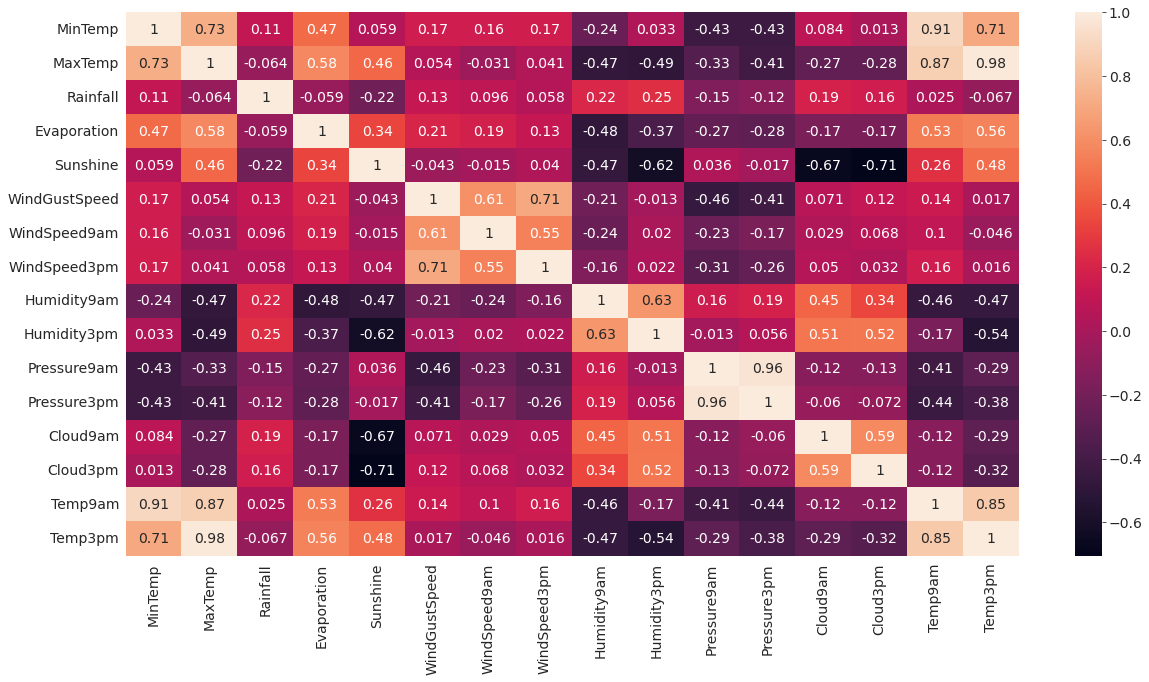

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(), annot = True)

Из приведенной выше тепловой карты корреляции мы видим, что есть несколько функций, которые влияют на другие и могут быть названы положительно коррелированными.

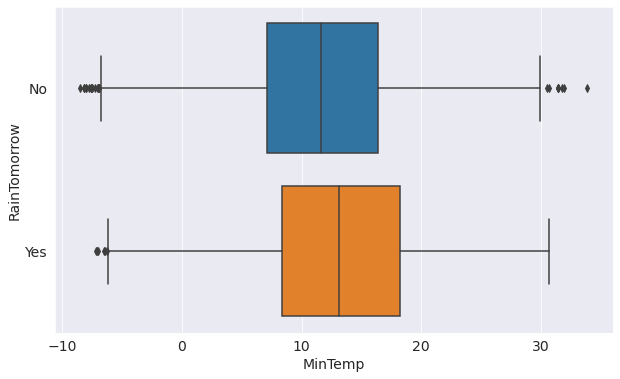

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style("darkgrid")

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.boxplot(x = "MinTemp", y = "RainTomorrow", data = data, dodge = True);

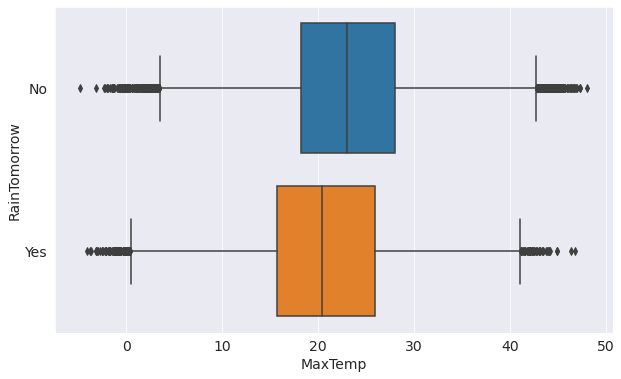

In [ ]:
sns.boxplot(x = "MaxTemp", y = "RainTomorrow", data = data, dodge = True);

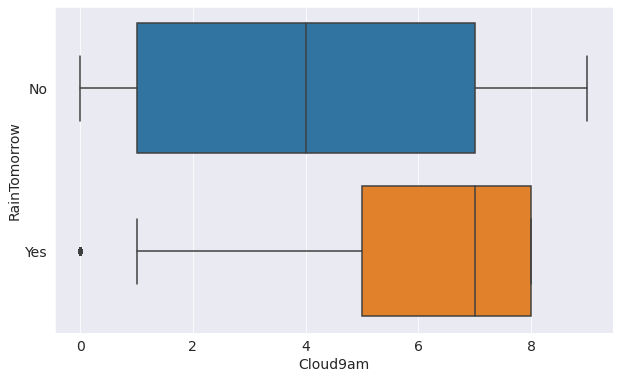

In [ ]:
sns.boxplot(x = "Cloud9am", y = "RainTomorrow", data = data, dodge = True);

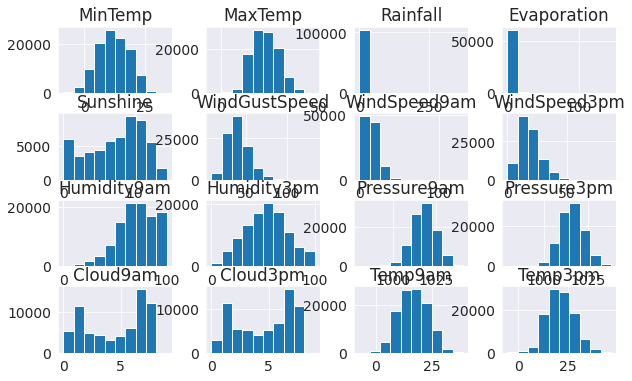

In [ ]:
data.hist()
plt.show()

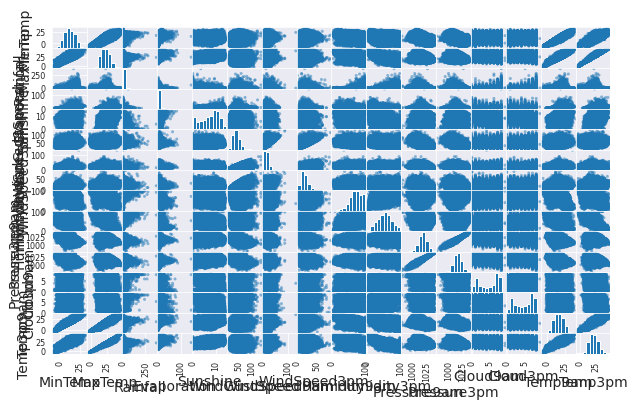

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(data)
plt.show()

Так как датасет представляет задачу бинарной классификации, то в качестве метрики качества можно взять accuracy, recall, precision,f1, но я возьму в качестве метрики accuracy score как стандартную метрику для таких задач.

In [ ]:
def Accuracy(Y_val, Y_pred):
    TP = (Y_val * Y_pred).sum()
    TN = np.logical_not(Y_val | Y_pred).sum()
    return (TP + TN) / len(Y_val)

def Precision(Y_val, Y_pred):
    TP = (Y_val * Y_pred).sum()
    return TP / Y_pred.sum()

def Recall(Y_val, Y_pred):
    TP = (Y_val * Y_pred).sum()
    return TP / Y_val.sum()

def F1_score(Y_val, Y_pred):
    precision = Precision(Y_val, Y_pred)
    recall = Recall(Y_val, Y_pred)
    return 2.0 * recall * precision / (precision + recall)

In [ ]:
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

def logit_loss(wx, y_real):
    return np.log(1.0 + np.exp(-wx*y_real)).sum()

def logit_grad(x, y, w):
    koeff = (y * sigmoid(-y*x.dot(w)))
    koeff = koeff.reshape((koeff.shape[0], 1))
    return -(koeff * x).sum(axis = 0)

class BinaryLogisticRegression:

    def __init__(self, speed = 1.5, reg_type=None, C=2.0, eps=0.001, maxsteps=200):
        self.solver = GradientDescent(speed, logit_grad, reg_type, C, eps, maxsteps)
        self.w = None
        
    def fit(self, X_train, Y_train):
        Y = np.array(Y_train)
        Y[Y_train == 0] = -1
        x0 = np.ones((X_train.shape[0], 1))
        X = np.hstack((x0, X_train))
        self.w = self.solver.fit(X, Y)
        return self
    

    def predict(self, X_val, border = 0):
        x0 = np.ones((X_val.shape[0], 1))
        X = np.hstack((x0, X_val))
        Xw = X.dot(self.w)
        Y_pred = np.zeros(Xw.shape).astype(np.int8)
        Y_pred[Xw >= border] = 1
        return Y_pred
    
    
    def predict_proba(self, X_val):
        
        x0 = np.ones((X_val.shape[0], 1))
        X = np.hstack((x0, X_val))
        Xw = X.dot(self.w)
        return sigmoid(Xw)
    
   
    def score(self, X_val, Y_val, metric=Accuracy):
        return metric(Y_val, self.predict(X_val))
    
    def weights(self):
        return self.w


In [ ]:
def L2_norm(vector):
    return (vector**2).sum()

def L1_norm(vector):
    return np.abs(vec).sum()

def L2_grad(vector):
    return vector

def L1_grad(vector):
    return vector / np.abs(vector)

class GradientDescent:
    def __init__(self, speed, gradient_func, regulasator=None, 
                 C=10.0, eps = 0.001, maxsteps=250):
        self.speed = speed
        self.function = gradient_func
        self.maxsteps = maxsteps
        self.eps = eps
        if regulasator == "l1":
            self.regulasator = lambda w:  L1_grad(w) / C
        elif regulasator == "l2":
            self.regulasator = lambda w: L2_grad(w) / C
        else:
            self.regulasator = lambda w: 0.0
    
    def fit(self, X_train, Y_train):
        w0 = np.zeros(X_train.shape[1])
        w = np.random.random(X_train.shape[1])
        k = 1
        while np.linalg.norm(w - w0) > self.eps and k <= self.maxsteps:
            w0 = w
            temp = self.speed * ((1 / k)**0.5) 
            w = w - temp*(self.function(X_train, Y_train, w) + self.regulasator(w))
            k += 1
            
        return w

In [ ]:
my_model = BinaryLogisticRegression()
my_model.fit(X_train, Y_train)

In [ ]:
print('accuracy score on train: ' + str(my_model.score(X_train, Y_train)))
print('accuracy score on test: ' + str(my_model.score(X_test, Y_test)))

accuracy score on train: 0.8033559902931604
accuracy score on test: 0.7864088100993822


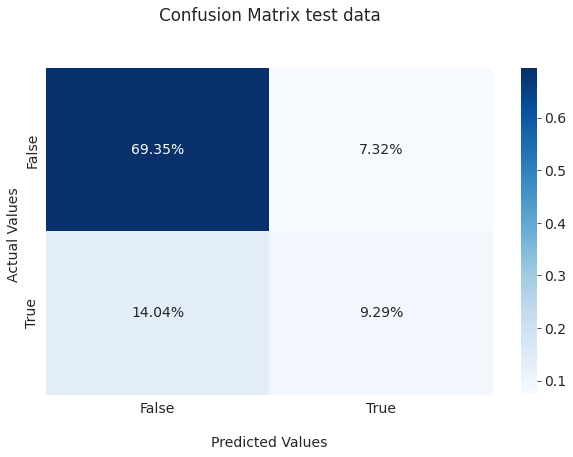

In [ ]:
y_pred_train = my_model.predict(X_train)
y_pred_test = my_model.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(Y_test, y_pred_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix test data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

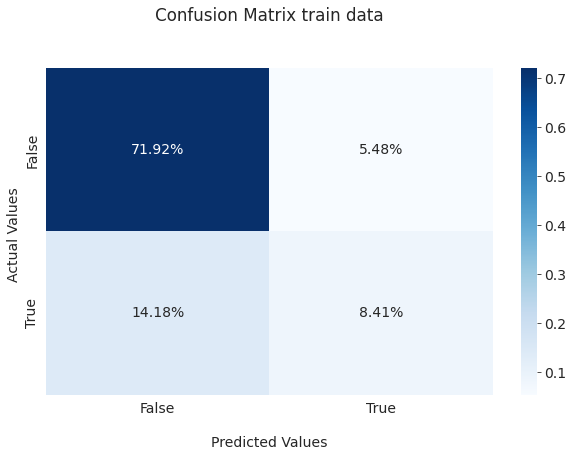

In [ ]:
cf_matrix = confusion_matrix(Y_train, y_pred_train)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix train data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

0.8468987567424582
0.837818963201719


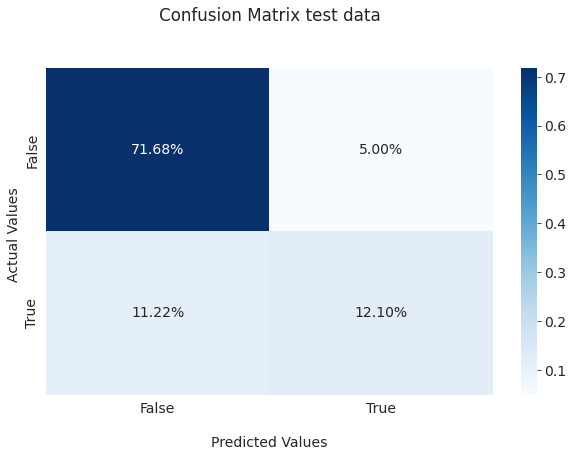

In [ ]:
y_pred_train1 = model.predict(X_train)
y_pred_test1 = model.predict(X_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(Y_test, y_pred_test1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix test data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

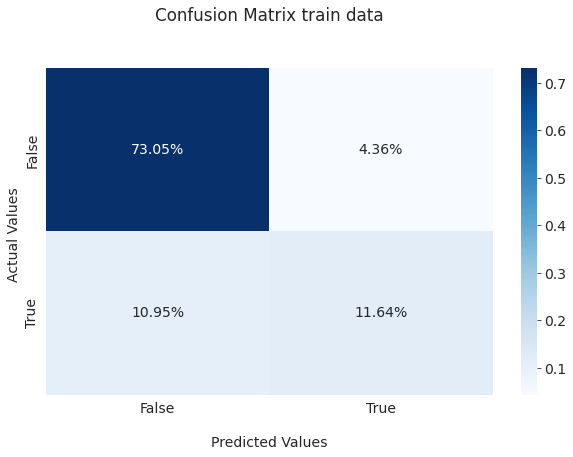

In [ ]:
cf_matrix = confusion_matrix(Y_train, y_pred_train1)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix train data\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

Как можно заметить по графикам, собственная реализация и библиотечный классификатор имеют низкий процент true positive results, что влияет на score. Это может быть связано с тем, что в самом датасете негативных значений целевой переменной почти в 3 раза больше, чем позитивных, на это так же указывает матрица и то, что библиотечная реализация показывает схожие результаты с моей, то есть это не является ошибкой написания собственного классификатора.